In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [49]:
plot_themes()

In [2]:
#export
from exp.nb_04 import *

In [4]:
x_train,y_train,x_valid,y_valid = get_data(mnist_path)

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [5]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [6]:
nfs = [8,16,32,64,64]

In [7]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [9]:
%timeit run.fit(2, learn)

train: [1.274519296875, tensor(0.5677, device='cuda:0')]
valid: [0.254298486328125, tensor(0.9161, device='cuda:0')]
train: [0.20001140625, tensor(0.9379, device='cuda:0')]
valid: [0.1551947265625, tensor(0.9505, device='cuda:0')]
train: [0.115702705078125, tensor(0.9635, device='cuda:0')]
valid: [0.09703432006835938, tensor(0.9702, device='cuda:0')]
train: [0.1141244140625, tensor(0.9651, device='cuda:0')]
valid: [0.09737936401367188, tensor(0.9693, device='cuda:0')]
train: [0.07399708984375, tensor(0.9765, device='cuda:0')]
valid: [0.079191650390625, tensor(0.9764, device='cuda:0')]
train: [0.0577385986328125, tensor(0.9809, device='cuda:0')]
valid: [0.0905842041015625, tensor(0.9730, device='cuda:0')]
train: [0.0490277587890625, tensor(0.9845, device='cuda:0')]
valid: [0.08176608276367188, tensor(0.9764, device='cuda:0')]
train: [0.133628544921875, tensor(0.9632, device='cuda:0')]
valid: [0.1641624755859375, tensor(0.9506, device='cuda:0')]
train: [0.0752964697265625, tensor(0.9759,

## Custom Batchnorm

In [10]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [41]:
xb, yb=next(iter(data.train_dl))

In [43]:
xb.mean((0,2,3), keepdim=True)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [44]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [51]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [52]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train: [0.28555361328125, tensor(0.9119, device='cuda:0')]
valid: [0.17666099853515624, tensor(0.9455, device='cuda:0')]


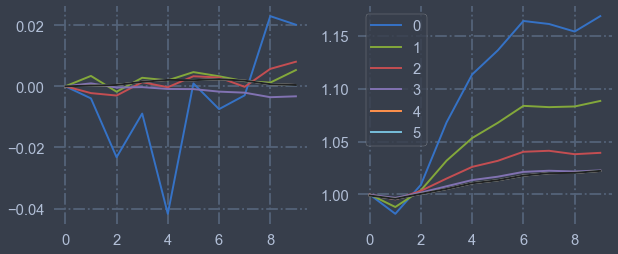

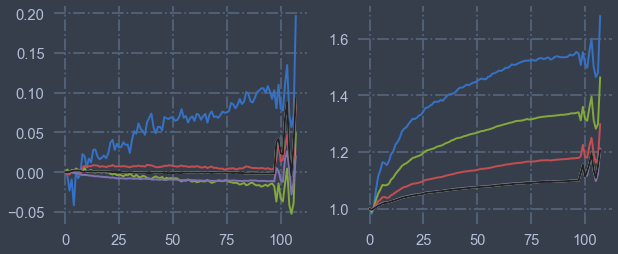

In [53]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)